In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import libs.data as data
import libs.utils as utils
import libs.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import libs.preprocessing as pp
import libs.semantics.vsm as vsm
import exp_libs.features as f
%matplotlib inline
import spacy
reload(vsm)

<module 'libs.semantics.vsm' from '../../../libs/semantics/vsm.py'>

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [3]:
df = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter_wa.csv')
df.head(2)

ID  AID  QID                                             Prompt  \
0  1.1    1    1   What is the role of a prototype program in pr...   
1  1.1    1    1   What is the role of a prototype program in pr...   

                                                  MA  \
0   To simulate the behaviour of portions of the ...   
1   To simulate the behaviour of portions of the ...   

                                                 MA2  \
0  to provide an example and feedback of how the ...   
1  to provide an example and feedback of how the ...   

                                                 MA3  \
0  to serve as a proof of concept and illustrate ...   
1  to serve as a proof of concept and illustrate ...   

                               NA  \
0  to find errors or collect data   
1  to find errors or collect data   

                                                  SA  MyScore  \
0   High risk problems are address in the prototy...        4   
1                                            no idea        0   

           Feedback  Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect             NaN    3.5             2             1  
1   wrong_unrelated  missed_concept    0.0             0             0

In [5]:
nlp_en = spacy.load('en')

In [6]:
import gensim.downloader as api
model_en = api.load('fasttext-wiki-news-subwords-300')

In [8]:
# Preprocessing Functions
# Keeps all stopwords, remove DET, PUNCT, SPACE,
preprocess_basic = f.create_preprocess_basic(nlp_en)
preprocess_not = f.create_preprocess_not(nlp_en)

def preprocess_basic_stops(x):
    tokens = preprocess_basic(x)
    return [t for t in tokens if not t in pp.EN_STOPS]

def preprocess_not_stops(x):
    tokens = preprocess_not(x)
    return [t for t in tokens if not t in pp.EN_STOPS]


word2word_fn = f.create_word_to_word_similarity_function(model_en)

In [14]:
df_all = pd.read_csv('../tmp/all_features.csv', sep='~', index_col=False)
df_all.head(2)
df_all.columns

Index(['Entailment_N3_MA1', 'Entailment_N3_MA2', 'Entailment_N3_MA3',
       'Cosine_Coeff_MA1', 'Cosine_Coeff_MA2', 'Cosine_Coeff_MA3',
       'Cosine_Coeff_Not_MA1', 'Cosine_Coeff_Not_MA2', 'Cosine_Coeff_Not_MA3',
       'Length_Diff_MA1', 'Length_Diff_MA2', 'Length_Diff_MA3', 'CV_N1_MA1',
       'CV_N1_MA2', 'CV_N1_MA3', 'CV_N2_MA1', 'CV_N2_MA2', 'CV_N2_MA3',
       'CV_N3_MA1', 'CV_N3_MA2', 'CV_N3_MA3', 'Token_Edit_Sim_MA1',
       'Token_Edit_Sim_MA2', 'Token_Edit_Sim_MA3', 'WM_Sim_MA1', 'WM_Sim_MA2',
       'WM_Sim_MA3'],
      dtype='object')

## Label Features:

In [25]:
df['Feedback_Notes'] = df['Feedback_Notes'].replace(np.nan, '')
misspelling = df['Feedback_Notes'].str.contains('misspelling').astype(int)
partially_missed_concept = np.logical_or(df['Feedback_Notes'].str.contains('partially_missed_concept'), df['Feedback_Notes'].str.contains('not_enough_info')).astype(int)
missed_concept = np.logical_and(~df['Feedback_Notes'].str.contains('partially_missed_concept'), df['Feedback_Notes'].str.contains('missed_concept')).astype(int)
false_assertion = np.logical_or(df['Feedback_Notes'].str.contains('false_assertion'), df['Feedback_Notes'].str.contains('shows_lack_of_knowledge')).astype(int)

## Exp. 01.1: Multilayer Perceptron Solver

Only use 1 Model Answer

In [35]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,128,64), random_state=1)

feature_columns_ma1 = [ 'COS_COEFF', 'COS_COEFF_NOT', 
                    'ENTAILMENT_N3', 'WM_SIM',
                    'CV_N1', 'CV_N2', 'CV_N3',
                    'LENGTH_DIFF', 'TOKEN_EDIT_SIM', 'Partially_Missed_Concept', 'Missed_Concept']

feature_vectors_ma1 = np.array([
  df_all['Cosine_Coeff_MA1'], df_all['Cosine_Coeff_Not_MA1'],
  df_all['Entailment_N3_MA1'], df_all['WM_Sim_MA1'],
  df_all['CV_N1_MA1'], df_all['CV_N2_MA1'], df_all['CV_N3_MA1'],
  utils.min_max_normalization(df_all['Length_Diff_MA1']), df_all['Token_Edit_Sim_MA1'],
  partially_missed_concept, missed_concept
])

df_features_ma1 = pd.DataFrame(feature_vectors_ma1.T, columns=feature_columns_ma1)

y_true_2 = df['Class2_Score']
y_true_3 = df['Class3_Score']

pred_results_ma1 = cross_val_predict(mlp_clf, df_features_ma1.as_matrix(), y_true_3, cv=5)

results_ma1 = stats.get_all_stats(y_true_3, pred_results_ma1)
stats.print_all_stats(y_true_3, pred_results_ma1)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results_ma1), classes=np.arange(3))
data.save('../tmp/results/labels_mlp_cross_validate_5_class3_ma1', results_ma1)

             precision    recall  f1-score   support

          0       0.83      0.85      0.84      1281
          1       0.73      0.52      0.60       644
          2       0.80      0.93      0.86       949

avg / total       0.80      0.80      0.79      2874

Pearson's R: 0.7912960091584281
Cohen's Kappa: 0.687321596775071
MAE: -0.0476687543493389
Accuracy: 80.17%
Precision: 79.68%
Recall: 80.17%
F1-Measure: 79.35%


             precision    recall  f1-score   support

          0       0.83      0.86      0.85      1281
          1       0.76      0.52      0.62       644
          2       0.80      0.93      0.86       949

avg / total       0.81      0.81      0.80      2874

Pearson's R: 0.7976088022264669
Cohen's Kappa: 0.7001925369029064
MAE: -0.03653444676409186
Accuracy: 81.04%
Precision: 80.70%
Recall: 81.04%
F1-Measure: 80.18%


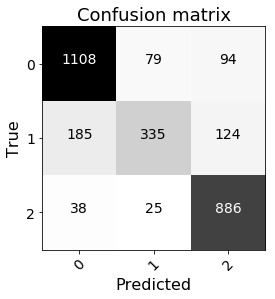

In [36]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=1)

pred_results_ma1_rf = cross_val_predict(rf_clf, df_features_ma1.as_matrix(), y_true_3, cv=5)

results_ma1_rf = stats.get_all_stats(y_true_3, pred_results_ma1_rf)
stats.print_all_stats(y_true_3, pred_results_ma1_rf)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results_ma1_rf), classes=np.arange(3))
data.save('../tmp/results/labels_random_forest_cross_validate_5_class3_ma1', results_ma1_rf)

             precision    recall  f1-score   support

          0       0.85      0.87      0.86      1281
          1       0.81      0.52      0.63       644
          2       0.80      0.97      0.87       949

avg / total       0.82      0.82      0.81      2874

Pearson's R: 0.8162859217327584
Cohen's Kappa: 0.7200531851986235
MAE: -0.06541405706332637
Accuracy: 82.29%
Precision: 82.37%
Recall: 82.29%
F1-Measure: 81.32%


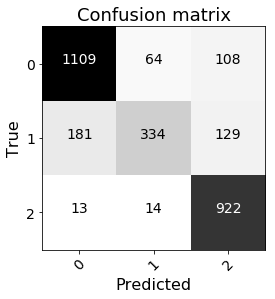

In [37]:
logreg = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial')

pred_results_ma1_logreg = cross_val_predict(logreg, df_features_ma1.as_matrix(), y_true_3, cv=5)

results_ma1_logreg = stats.get_all_stats(y_true_3, pred_results_ma1_logreg)
stats.print_all_stats(y_true_3, pred_results_ma1_logreg)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results_ma1_logreg), classes=np.arange(3))
data.save('../tmp/results/labels_logreg_cross_validate_5_class3_ma1', results_ma1_logreg)

In [28]:
# Pass/Fail
pred_results_ma1_pf = cross_val_predict(mlp_clf, df_features_ma1.as_matrix(), y_true_2, cv=5)

results_ma1_pf = stats.get_all_stats(y_true_2, pred_results_ma1_pf)
stats.print_all_stats(y_true_2, pred_results_ma1_pf)
stats.plot_confusion_matrix(stats.cm(y_true_2, pred_results_ma1_pf), classes=np.arange(2))
data.save('../tmp/results/labels_mlp_cross_validate_5_class2_ma1', results_ma1_pf)

             precision    recall  f1-score   support

          0       0.85      0.85      0.85      1341
          1       0.87      0.87      0.87      1533

avg / total       0.86      0.86      0.86      2874

Pearson's R: 0.7216618812001665
Cohen's Kappa: 0.7216364637221533
MAE: -0.0041753653444676405
Accuracy: 86.15%
Precision: 86.15%
Recall: 86.15%
F1-Measure: 86.15%


In [48]:
## New Upper Bounds for 3-Class Grading
stats.print_all_stats(utils.convert_to_class3(np.round(df['Score'].values)), utils.convert_to_class3(df['MyScore']))

             precision    recall  f1-score   support

        0.0       0.79      0.95      0.87      1120
        1.0       0.15      0.27      0.19       157
        2.0       0.96      0.75      0.84      1597

avg / total       0.85      0.80      0.81      2874

Pearson's R: 0.7911824820073483
Cohen's Kappa: 0.6522520521517847
MAE: 0.2000695894224078
Accuracy: 80.10%
Precision: 85.12%
Recall: 80.10%
F1-Measure: 81.50%


In [176]:
# How does it break down per problem?

def inspect_results(df, y_true, y_pred):
    idxs = np.unique(df['ID'].values)
    
    for idx in idxs:
        mask = df['ID'] == idx
        tmp_true = y_true[mask]
        tmp_pred = y_pred[mask]
        print('=============')
        print('ID: {}'.format(idx))
        stats.print_all_stats(tmp_true, tmp_pred)
        stats.plot_confusion_matrix(stats.cm(tmp_true, tmp_pred), classes=np.arange(3))
        print('=============')

y_pred = clf.predict(df_features.as_matrix())
#inspect_results(df3, df3['Class3_Score'], y_pred)

In [30]:
import libs.debug.tsne as tsne

pca = tsne.compute(df_features_ma1.as_matrix(), perplexity=50)

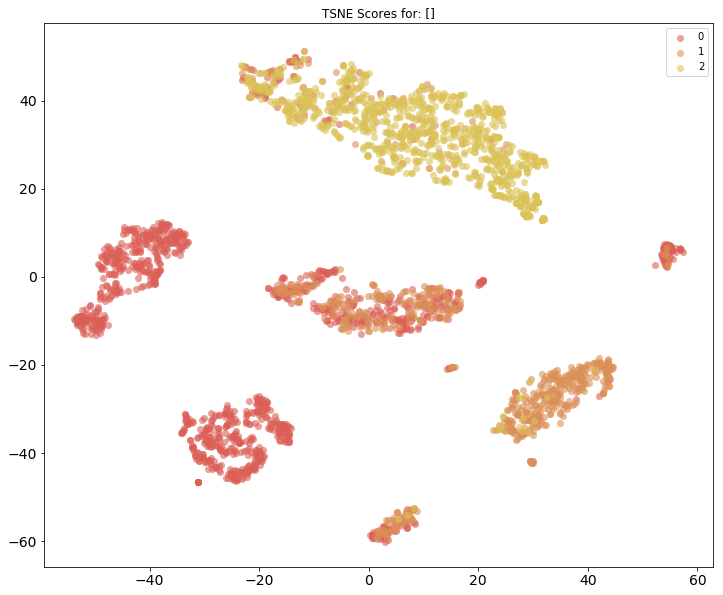

In [31]:
tsne.plot(pca, df['Class3_Score'])

In [98]:
dfc = df_features.copy()
dfc['SA'] = df['SA']
dfc['Score3'] = df['Class3_Score'] 

# short wrong answers
#idxs = tsne.get_indexes(pca, [-20, 20], [-75, -40])
#df[idxs]

#idxs = tsne.get_indexes(pca, [-80, -55], [-30, 20])
#dfc[idxs]

In [99]:
def test_student_response(clf, qid, model_answer, neg_answer, student_response, min_max=[0,1]):
    
    # feature 01
    f1 = count_vec(model_answer, student_response)
    
    # feature 02
    ma2 = preprocess_fn(model_answer)
    sa2 = preprocess_fn(student_response)
    f2 = cosine_coefficient(set(ma2), set(sa2))
    
    # feature 03 : cosine sim w/not
    ma3 = preprocess_not(model_answer)
    sa3 = preprocess_not(student_response)
    f3 = cosine_coefficient(set(ma3), set(sa3))
    
    # feature 04 : length difference
    ma = [t.lemma_ for t in nlp_en(model_answer) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    sa = [t.lemma_ for t in nlp_en(student_response) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    f4 = len(ma) - len(sa)
    f4 = (f4 - min_max[0]) / (min_max[1] - min_max[0])
    
    # feature 05 : vector similarity
    ma = pipeline_fn(row['MA'])
    sa = pipeline_fn(row['SA'])
    ma_t = nlp_en(' '.join(ma))
    sa_t = nlp_en(' '.join(sa))
    f5 = ma_t.similarity(sa_t)
    
    # feature 06
    na = preprocess_stops(neg_answer)
    sa6 = preprocess_stops(student_response)
    f6 = cosine_coefficient(set(na), set(sa2))
    
    # ID one-hot encoding feature
    cols = question_id_features.columns.tolist()
    id_one_hot = np.zeros(len(cols), dtype=np.int)
    id_one_hot[cols.index(qid)] = 1
    f7 = id_one_hot.tolist()
    
    vec = np.array([f1,f2,f3,f4,f5,f6] + f7)
    print(vec[:7])
    
    return clf.predict([vec])


idx = 100
qid = df.iloc[idx]['ID']
ma = df.iloc[idx]['MA']
prompt = df.iloc[idx]['Prompt']
na = df.iloc[idx]['NA']
print('[{}]: {}'.format(qid, prompt))
print(ma)
test_student_response(clf, qid, ma, na, "abstraction and reusability", min_max=[norm_min, norm_max])

[1.3]:  What are the main advantages associated with object-oriented programming? 
 Abstraction and reusability. 


NameError: name 'count_vec' is not defined

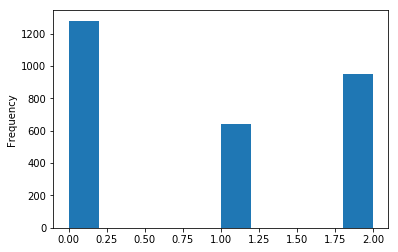

In [239]:
df3['Class3_Score'].plot(kind='hist')